In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from split import *
from score import *
from scipy import interpolate
import time 
%matplotlib inline 
import warnings 
warnings.simplefilter('ignore', np.RankWarning)
import matplotlib.pyplot as plt
import matplotlib



"""
Title:       Search_By_Triplet + TIME_RESOLUTION + Origin_Cut + . 

Status:      Stable 

Autor:       Piter Amador Paye Mamani.

Description:
             This python-code is an implementation of the algorithm Search By Triplet that was inspired on the work of
             Daniel Campora plus a litle modifications.         
Changes:
        * Reviewing the cuts on the track_seeding
        * Use dr instead of dx and dy [doing]                                 
        * Reviewing the units                                           
        * Making changes on the time.                                   
        * Finally, the time information is added.                   
        * A very good code without time is completly developed.    
        * New restrictions are applied at the seeding algorithm.   
        * 
        * Implementing the z cut. [doing]
        * Change np.arctan() by np.arctan2()

1.  Squeletum of the algorithm
2.  First Tracks. 
5.  Adding exceptions. 
6.  I've deleted unnecessary comments. Also, I was getting an error at time to compute findcandidatewindows.
    Problems. One get the values of tracks 
7.  Changing the jerarquy of the function, according to the paper. It means that findcandidatewindows is calculated
    on all modules befero they were processed.
6.  
7.  
8.  I've added the information of weak_tracks and I've added the information of USED and NOt USED 
9.  dphi  is a constant value
9.  Adding timing information 

10. In this version I will plot a graphic of efficiency in function of dphi. 
    Here, I am not concentrating on the plots of the tracks. Only on the plots of the efficiency that depend on dphi.
    In other words. I have to run the main program and get the values of the efficiency and then plot. 
    I am thinking on work only with 0.004 percent of the data. Because it is more fast than all data. 
    
11. Adding TIMING TO THE ALGORITHM.     
    To add timing information to the algorithm 
    I've do it previoues analysis like see if the time difference follow a gaussian distribution.
    Plus another important question is to see. How we can add the new restriction to our values. 
    
    I refer that I have to compute the difference in time between t1 and t2 to see if the values surpasses a new technological approach. 
12. The timing information was added to this algorithm. However, the serach by triplet algorithm is falling according to (probably) 
    the lost of one variable. It means that when we are using phi, it depend on the x and y. However, the plots that I am getting are good 
    only for a xy superposed planes. In other words, the window variable on phi is a good candidate but it lost informatin on Z X and Z Y.
13. Code 
"""

"\nTitle:       Search_By_Triplet + TIME_RESOLUTION + Origin_Cut + . \n\nStatus:      Stable \n\nAutor:       Piter Amador Paye Mamani.\n\nDescription:\n             This python-code is an implementation of the algorithm Search By Triplet that was inspired on the work of\n             Daniel Campora plus a litle modifications.         \nChanges:\n        * Reviewing the cuts on the track_seeding\n        * Use dr instead of dx and dy [doing]                                 \n        * Reviewing the units                                           \n        * Making changes on the time.                                   \n        * Finally, the time information is added.                   \n        * A very good code without time is completly developed.    \n        * New restrictions are applied at the seeding algorithm.   \n        * \n        * Implementing the z cut. [doing]\n        * Change np.arctan() by np.arctan2()\n\n1.  Squeletum of the algorithm\n2.  First Tracks. \n5.  Addin

# Defining FUNCTIONS 

In [19]:
def rho(x,y):
    return np.sqrt(x*x + y*y)
def r(x,y,z):
    return np.sqrt(x*x + y*y + z*z)
def theta(x,y,z):
    return np.arccos(z/r(x,y,z))
def phi(x,y):
    return np.arctan2(y/x)
def module(r):
    return np.sqrt(np.sum(r*r))

def r_e(z, r_l, r_c):
    z_c = r_c[2] 
    r_versor = (r_l - r_c)/module(r_l - r_c)               # computing r_versor
    r_versor_dot_z_versor = r_versor[2]  
    return r_c - r_versor/r_versor_dot_z_versor*(z_c - z)  # IMPORTANT WITH THE MINUS SIGN.

def correct_time(hit_time, x, y, z):
    c = 0.299792 # Light Velocity in [mm/ps]  
    travel_time = np.sqrt(x*x + y*y + z*z)/c
    return hit_time - travel_time

def ext_func(r0, r):
    # r0, r1, r are arrays
    dx2_plus_dy2 = module(  r0-r )     # distance between hits on the working module.
    # dx2_plus_dy2 = (r0-r)[0] + r0-r[1] 
    """dz2       = module( r1-r0 )     # distance between the last two modules. # I do not use this anymore                         
    return dx2_plus_dy2/dz2 
    """  
    return dx2_plus_dy2 

def fit(triplet): 
    phi_data = [ df.query(f'hit_id == {hit}')['phi']     for hit in triplet ]
    z_data   = [ df.query(f'hit_id == {hit}')['z_mod']   for hit in triplet ]
    phi_data = [ hit.values[0] for hit in phi_data                          ]                        
    z_data   = [ hit.values[0] for hit in z_data                            ]                    
    # Kind of fit: Linear
    fitting = np.polyfit(phi_data, z_data, 1)
    chiSquared = np.sum((np.polyval(fitting, z_data) - phi_data)**2)
    return chiSquared

GRALDR1 = []
GRALDR2 = []
def DR(delta, dx, dy ): 
    global theta_scatt
    dr1 = 3*np.sqrt(dx*dx + dy*dy)
    GRALDR1.append(dr1)
    dr2 = delta*np.tan(theta_scatt)  
    GRALDR2.append(dr2)    
    return 2*max(dr1, dr2)
    #return np.sqrt(0.1**2 + 0.1**2)
    #return np.sqrt(dx*dx + dy*dy) # 3 sigma 

# Getting Data

In [20]:
def reading_data(fraction, event):
    global time_resolution           # Adding a time resolution to our analysis of tracks
    
    """
    EVENT
    55microns50psInner55microns50psOuter_EventNumber.txt [done]
    
    25microns0psInner200microns50psOuter_EventNumber.txt
    25microns0psInner200microns50psOuter_test.txt
    25microns75psInner25microns75psOuter_EventNumber.txt
    25microns75psInner25microns75psOuter_test.txt
    55microns0psInner55microns0psOuter_EventNumber.txt
    55microns0psInner55microns0psOuter_test.txt
    55microns100psInner200microns50psOuter_EventNumber.txt
    55microns100psInner200microns50psOuter_test.txt
    55microns50psInner55microns50psOuter_EventNumber.txt
    55microns50psInner55microns50psOuter_test.txt
    """
    
    name = 'EventData/25microns0psInner200microns50psOuter_EventNumber.txt' # To be modified for others files. 
    
    df = pd.DataFrame()
    df = pd.read_csv(name, sep=' ')              # All data.
    
    columns = df.columns.values
    columns[9] = 'Event'
    df.columns = columns

    df_tmp = df.query(f'Event == {event}' ) #.copy(deep = True)  # inplace=True)
    
    df_tmp2, _ = split_frac(df_tmp, fraction)
    
    return df_tmp2 

# First Part of the Algorithm
# A sort of the hits according to the value of $\phi$

In [21]:
def sortbyphi():
    '''Description:
    Sort each D_i increasingly accoording to phi
    And add a column to the dataframe_module with the name of used to accept or neglect hits. 
    '''
    global time_resolution  
    global df 
    global nSigma_z 
    
    df['phi']   = np.arctan2(df['x'], df['y'])                        
    df['t_c']   = correct_time(df['t'], df['x'], df['y'], df['z'])        
    df['used']  = 0   
    df['delta'] = 0 # this is the distance from one module to another module -> in this sense
    
    modules = []
    z_modules = [-277.0, -252.0, -227.0, -202.0, -132.0, -62.0, -37.0, -12.0, 13.0, 38.0, 63.0, 88.0, 113.0, 138.0, 163.0, 188.0, 213.0, 238.0, 263.0, 325.0, 402.0, 497.0, 616.0, 661.0, 706.0, 751.0]
    
    for i in range(len(z_modules)-1,-1 ,-1):
        z_m = z_modules[i]
        #print(nSigma_z)
        mod = df.query(f" {z_m} - {nSigma_z} <= z <= {z_m} + {nSigma_z}").copy(deep=True)
        mod['z_mod'] = z_m 
        
        if i == 0 : 
            mod['delta'] = abs(277.0  -252.0)  # this value is a string. It is necessary to verify that delta is not used at  after. 
        else :
            #print(i)
            mod['delta'] =  z_modules[i] - z_modules[i-1] 
            #print("the distance difference between modules is :", i, i-1, "delta: ", z_modules[i] - z_modules[i-1]) 
        #mod.loc[mod.index.values, "z_mod"] = z_m
        #mod.loc[mod.index.values, "used"]  = False
        # IMPORTANT  
        mod = mod.sort_values('phi', ascending=True) 
        #print("Index ", mod['t_c'])
        modules.append(mod)  
        
    modules.reverse()  #sort=True) # necessary step
    
    tmp_df =pd.DataFrame()
    for mod in modules:
        tmp_df = pd.concat([tmp_df, mod])
    df = tmp_df
    #print(df['t_c'])
    return modules


# Second Part
## It is computed the hit values according to a search window on phi. 
## The value of d$\phi$ can be constant or variable.

In [22]:
#PHI = []
def findcandidatewindows(left_mod, mod, right_mod):
    #global left_mod, mod, right_mod
    #(left_mod, mod, right_mod ):
    global phi_extrapolation_coef, phi_extrapolation_base
    global dphi_cut
    global time_resolution               # Adding a time resolution to our analysis of tracks
    # phi_window     =  phi_extrapolation_base + np.abs( hit_Zs[h_center]) * phi_extrapolation_coef 
    global phi_extrapolation_coef, phi_extrapolation_base , dphi
    '''Description: 
        Compute the first and last candidates(the window) according to acceptance range(dphi) for each hit.
        SUPPOSSING THAT ALL DATA ARE ORDERED ACCOURDING TO PHI. THIS PROCCESS WAS DONE Previously
        In case of add more information to the modules, one easily can add throught the iteration 
    '''
    # CONVENTION :     
    # l_m  m  r_m   the values are ordered.      
    #  |   |   |             
    #  |   |   |    phi up  
    #  |   |   |    phi      
    #  |   |   |    phi down 
    #  |   |   |    
    right_hit_max = [] 
    right_hit_min = [] 
    
    temporal = mod['phi'] 
    
    # ITERATION OVER PHI FOR RIGHT 
    
    for phi_i in mod['phi']: 
        #print("=")
        #print(phi_i)
        if str(phi_i) == 'nan' :     
            #print(phi_i, "the value of phi_i is NaN ON RIGHT")
            m = "nan"               # minumum hit 
            M = "nan"               # maximum hit
            right_hit_min.append(m) 
            right_hit_max.append(M) 
            continue # 
        if str(phi_i) == 'NaN' :     
            #print(phi_i, "the value of phi_i is NaN ON RIGHT")
            m = "nan"               # minumum hit 
            M = "nan"               # maximum hit
            left_hit_min.append(m) 
            left_hit_max.append(M) 
            continue # 
            
        z_center = mod['z_mod'].unique()[0]           
        #z = df.query(f"phi=={phi_i}")["z"].values[0] 
        # GET HIT 
        if dphi_cut == True: 
            z_dphi = mod['z_mod'].unique()[0] 
            dphi =  phi_extrapolation_base + np.abs( z_dphi ) * phi_extrapolation_coef 
            #print("dphi :", dphi)

        #PHI.append(dphi)
        down      = phi_i - dphi 
        up        = phi_i + dphi 
        #print(down, up)
        
        condition = f'{down} <= phi <=  {up}'
        tmp_df = right_mod.query(condition)
        if not tmp_df.empty:
            m = tmp_df['hit_id'][tmp_df.index[0]]     # minumum hit 
            M = tmp_df['hit_id'][tmp_df.index[-1]]    # maximum hit 
            right_hit_min.append(m) 
            right_hit_max.append(M) 
        elif tmp_df.empty :

            m = "nan" #pd.np.nan                      # minumum hit 
            M = "nan" #pd.np.nan                      # maximum hit
            right_hit_min.append(m)  
            right_hit_max.append(M) 
            
    left_hit_max = [] 
    left_hit_min = [] 
    # ITERATION OVER PHI FOR LEFT
    for phi_i in mod['phi']:
        if str(phi_i) == 'NaN' :     
            # print(phi_i, "the value of phi_i is NaN ON LEFT")
            m = "nan"               # minumum hit 
            M = "nan"               # maximum hit
            left_hit_min.append(m) 
            left_hit_max.append(M) 
            continue # 
        if str(phi_i) == 'nan' :     
            # print(phi_i, "the value of phi_i is NaN ON left")
            m = "nan"               # minumum hit 
            M = "nan"               # maximum hit
            left_hit_min.append(m) 
            left_hit_max.append(M) 
            continue # 
        # GET HIT 
        if dphi_cut == True: 
            z_dphi = mod['z_mod'].unique()[0] 
            dphi = phi_extrapolation_base + np.abs( z_dphi ) * phi_extrapolation_coef 
            #print("dphi :", dphi)

        down      = phi_i - dphi 
        up        = phi_i + dphi 
        condition = f'{down} <= phi <= {up}'
        tmp_df = left_mod.query(condition)
        #print("len LEFT", len(tmp_df))
        if not tmp_df.empty :
            m = tmp_df['hit_id'][tmp_df.index[0]]        # minumum hit 
            M = tmp_df['hit_id'][tmp_df.index[-1]]       # maximum hit  
            left_hit_min.append(m)
            left_hit_max.append(M)
        elif tmp_df.empty :
            # print("data_frame is empty LEFT")
            m = "nan"               # minumum hit 
            M = "nan"               # maximum hit
            left_hit_min.append(m) 
            left_hit_max.append(M) 
            
    mod["right_hit_max"] = right_hit_max  
    mod["right_hit_min"] = right_hit_min  
    mod["left_hit_max"]  = left_hit_max   
    mod["left_hit_min"]  = left_hit_min                                                                                    
    return mod

###############################################

# New functions to extrapolate the hits

In [23]:
def extrapolation_on_center_module(r_right, r_left, z_center):
    # IMPORTANT
    # the values then have the next form:
    # np(r_right), np(r_left), float(r_left)
    #modules |  |  |
    #        l  c  r
    r_versor = (r_right - r_left)/module(r_right - r_left)   #  
    distance = abs( z_center - r_left[2] )                   # 
    r_center = r_left + distance / ( np.dot(r_versor, np.array([0,0,1]) ) ) * r_versor
    return r_center 

In [24]:
def extrapolation_to_origin(r1, r2, y):   # only works for y
                                          # in case to extrapolate for x you only need to change the values of r2 ->y2 and the unitary versor
    r_versor = (r1 - r2)/module(r1 - r2)  
    y2       = r2[1] 
    r_origin = r2 + (y2 - y)/( np.dot(r_versor, np.array([0,-1,0]) ) ) * r_versor 
    return r_origin 

# Third Part 
## Heart of the Algorithm. Seeding by triplets to form Tracks

In [25]:
T_L = []
T_R = []
T_C = []

X = []
Y = []
Z = []

DRCHISTOGRAM = []
def trackseeding(): 
    global circle, square, cut_on_z_origin, cut_dx_dy, circleCTE
    global dr
    global nSigma_z_origin
    global dx, dy
    global M_i
    global time_resolution                             # Adding a time resolution to our analysis of tracks
    global left_mod, mod, right_mod, M_i, dphi, nSigma_t
    '''
    Description: 
        
        * Modification to the code: 
        
        Checks the preceding and following modules for compatible hits using the above results.
        
        All triplets in the search window are fitted and compared.
        and the best one is kept as a track seed.
        
        stores its best found triplet
        Finding triplets is ap- plied in first instance to the modules
        that are further apart from the collision point
        Each triplet is the seed of a forming track
    '''
    #Necessary functions.

    df_triplets = []
    #print("error ??????", mod )
    # print("error_mod.columns:", mod.columns)
    for index, part in mod.iterrows():

        r_hit_max, r_hit_min = part["right_hit_max"], part["right_hit_min"]  
        l_hit_max, l_hit_min = part["left_hit_max"],  part["left_hit_min" ] 
        
        if  str(r_hit_max)  == "nan":
            continue 
        elif str(r_hit_min) == "nan":
            continue 
        elif str(l_hit_max) == "nan":
            continue 
        elif str(l_hit_min) == "nan":
            continue  
        if  str(r_hit_max)  == "NaN" :
            continue 
        elif str(r_hit_min) == "NaN" :
            continue 
        elif str(l_hit_max) == "NaN" :
            continue 
        elif str(l_hit_min) == "NaN" :
            continue  
        r_phi_max = right_mod.query(f"hit_id == {r_hit_max}")['phi'].values[0]   
        r_phi_min = right_mod.query(f"hit_id == {r_hit_min}")['phi'].values[0]   
                                                                                 
        l_phi_max = left_mod.query(f"hit_id == {l_hit_max}")['phi'].values[0]   
        l_phi_min = left_mod.query(f"hit_id == {l_hit_min}")['phi'].values[0]     
        
        # ITERATION OVER RIGHT      
        tmp_right = right_mod.query(f"   {r_phi_min} <= phi <= {r_phi_max} & used == False ")    
        for hit_right in tmp_right['hit_id'].values: 
            # ITERATION OVER LEFT   
            tmp_left = left_mod.query(f" {l_phi_min} <= phi <= {l_phi_max} & used == False ")   
            for hit_left in tmp_left['hit_id'].values: 
                hit_center = int( part["hit_id"] )    
                # At this point we form all triplets. 
                ############################################################################################################ 
                ########################################   TIMING   ######################################################## 
                ############################################################################################################ 
                # NOTATION: 't_c' is the corrected time. Against of t_c that is the time variable of the modules t_center   
                if time_resolution == True :
                    # print("time_resolution == True")
                    t_l =   left_mod.query(f'hit_id == {hit_left}')['t_c'].values[0]
                    t_c =      mod.query(f'hit_id == {hit_center}')['t_c'].values[0]
                    t_r = right_mod.query(f'hit_id == {hit_right}')['t_c'].values[0]
                    
                    # CONDITIONS:
                    T_L.append(abs(t_l - t_c))
                    T_C.append(abs(t_c - t_r))
                    T_R.append(abs(t_l - t_r))
                    
                    if abs(t_l - t_c) > nSigma_t : # 3*sigma_t :
                        continue
                    if abs(t_c - t_r) > nSigma_t : # 3*sigma_t :
                        continue
                    if abs(t_l - t_r) > nSigma_t : # 3*sigma_t :
                        continue
                ########################################   END - TIMING   ####################################################       

                try : # GETTING THE VALUES
                    r_right  = tmp_right.query(f'hit_id == {hit_right} ')[['x', 'y','z']].to_numpy()[0]
                    z_center = part['z_mod']                            
                    r_left   = tmp_left.query(f'hit_id == {hit_left} ')[['x', 'y','z']].to_numpy()[0] 
                    z_left   = tmp_left.query(f'hit_id == {hit_left} ')['z'].to_numpy()[0]            
                    r_center = np.array( [ part['x'], part['y'], part['z_mod'] ] )
                    r_left   = tmp_left.query(f'hit_id == {hit_left} ')[['x', 'y','z']].to_numpy()[0]
                    r_center_extrapolation = extrapolation_on_center_module(r_right, r_left, z_center) # this value it was already computed 

                except :
                    print("here there is a problem. Where we get the values.")
                    return 1
                
                #############################################################################################################
                ########### IMPLEMENTATION OF THE dx2_plus_dy2 < 0.1 on the left module. Not explained on the article. Proposed by D.C.
                #############################################################################################################
                r_ext_left     = r_e( z_left, r_center, r_right)     # Extrapolation on the left module. 
                ext_func_value = ext_func( r_ext_left, r_left )      # EXTRAPOLATION. DISTANCE between two points

                if cut_dx_dy == True :
                    if ext_func_value < 0.1 : 
                        pass
                    else :
                        continue

                """ #In the case to plot the extrapolation values and to plot the
                try :
                    r_center_extrapolation = extrapolation_on_center_module(r_right, r_left, z_center) # this value it was already computed 
                    # MAKING A PROOF ON THE EXTRAPOLATION OF DATA. PLOTING THE VALUES OF X Y Z 
                    # make a plot of r_left and r_right and r_extrapolated
                    #r_left, r_center_extrapolation, r_right 
                    
                    x_hits = [r_left[0], r_center_extrapolation[0], r_right[0] ]
                    y_hits = [r_left[1], r_center_extrapolation[1], r_right[1] ]
                    z_hits = [r_left[2], r_center_extrapolation[2], r_right[2] ]
                    
                    verification = r_left[2] < r_center_extrapolation[2] < r_right[2]
                    if verification == False :
                        print("verifing if the value of z_center is on the ")
                        print(verification)
                    #print(temporal, type(temporal))
                except :    
                    print("here is the error ont the extrapolation==")
                    return 1 
                """ 
                ############################################################################################################ 
                ########################################   CUT on Z   ###################################################### 
                ############################################################################################################   
                if cut_on_z_origin == True :
                    try:
                        x0 , y0,  z0 = extrapolation_to_origin(r1 = r_right, r2 = r_left, y = 0)  
                        #if y0 != 0 :
                        #    print("the value of y0 is :", y0)
                        #X.append(x0) 
                        #Y.append(y0) 
                        #Z.append(z0) 
                        if  abs(z0) > nSigma_z_origin:
                            #print("z0 > sigma_origin: ")
                            continue 
                    except : 
                        print("the error is on cut_on_z_origin")
                
                x_e = r_center_extrapolation[0] 
                y_e = r_center_extrapolation[1] 
                x = part['x'] 
                y = part['y'] 
                
                # print("left_cut_x", "right_cut_x", "down_cut_y", "up_cut_y")  
                # print(left_cut_x, right_cut_x, down_cut_y, up_cut_y)          
                
                ############################################################################################################ 
                ###############   RECTANGLE WINDOW on dx and dy  CONSTANT VALUES       #####################################             
                if square == True : 
                    try : 
                        left_cut_x  = x_e - dx 
                        right_cut_x = x_e + dx  
                        down_cut_y  = y_e - dy 
                        up_cut_y    = y_e + dy       
                        #print("verifying the kind of x and y ", x, y, type(x), type(y)) 
                        if  (left_cut_x < x < right_cut_x) and (down_cut_y < y < up_cut_y) :
                            pass
                        else :
                            continue # continue searching
                    except :
                        print("the error is in rectangle" )
                        return 0
                
                elif circle == True : 
                    try :
                        dxC    = part['dx']   
                        dyC    = part['dy']    
                        dzC    = part['dz']    
                        deltaC = part['delta'] 
                    except : 
                        print("the error is in assign variables")
                        return 0
                    try :
                        drC = DR(deltaC, dxC, dyC )
                    except :
                        print("DR error")
                        return 0
                    
                    drValue = np.sqrt( (x - x_e )**2 + ( y - y_e )**2 )
                    DRCHISTOGRAM.append(drC)
                    
                    if (drValue < drC) : 
                        """
                        #if len(new_window) > 0 :
                        print("PROOF", part[['x', 'y', 'z']].to_numpy())
                        point = part[['x', 'y', 'z']].to_numpy()
                        plt.plot(z_hits, x_hits) 
                        plt.scatter(z_hits + [ point[2], point[2], point[2]], x_hits+[point[0], left_cut_x, right_cut_x] )
                        plt.xlabel("z")
                        plt.ylabel("x")
                        plt.show() 
                        plt.plot(z_hits, y_hits ) 
                        plt.scatter(z_hits + [ point[2], point[2], point[2]], y_hits+[point[1], down_cut_y, up_cut_y] )
                        plt.xlabel("z")
                        plt.ylabel("y")
                        plt.show()
                        """
                        pass

                    else:
                        continue 
                        
                
                elif circleCTE == True : 
                    try :  
                        deltaCTE = part['delta'] 
                    except : 
                        print("the error is in assign variables")
                        return 0
                    try :
                        drC = DR(deltaCTE, dx, dy )
                    except :
                        print("DR error")
                        return 0
                    
                    drValue = np.sqrt( ( x - x_e )**2 + ( y - y_e )**2 )
                    
                    if (drValue <  drC) : 
                        """
                        #if len(new_window) > 0 :
                        print("PROOF", part[['x', 'y', 'z']].to_numpy())
                        point = part[['x', 'y', 'z']].to_numpy()
                        plt.plot(z_hits, x_hits) 
                        plt.scatter(z_hits + [ point[2], point[2], point[2]], x_hits+[point[0], left_cut_x, right_cut_x] )
                        plt.xlabel("z")
                        plt.ylabel("x")
                        plt.show() 
                        plt.plot(z_hits, y_hits ) 
                        plt.scatter(z_hits + [ point[2], point[2], point[2]], y_hits+[point[1], down_cut_y, up_cut_y] )
                        plt.xlabel("z")
                        plt.ylabel("y")
                        plt.show()
                        """
                        pass

                    else:
                        continue 
                
                #print("print the new window", len(new_window)
                
                ############################################################################################################ 
                ##############################  END CUTS  ################################################################## 
                ############################################################################################################ 
                             
                # Adding new triplets 
                triplets = [hit_left, hit_center, hit_right] 
                
                # This a lost of memory. I mean that call by hits and not by values is a lost of memory.
                chi2 = fit(triplets)                                                                                                                                                                
                # Finally we append the values of the data to a df_triplets
                df_triplets.append(list(triplets)+[chi2])
                        
    df_triplets = pd.DataFrame(df_triplets, columns = ['left_hit', 'hit', 'right_hit', 'chi2'])      
    # Up to this point it is necessary to have the values of df_triplets complete
    # Then the algorithm should continue to get the best choices according to the values
    # of chi2. 
    
    def best_choice(df_triplets):
        seeds = []
        for hit_c in df_triplets['hit'].unique() : # UNIQUE
            # GROUPING 
            tmp = df_triplets.query(f'hit == {hit_c}')
            minimum = (tmp['chi2']).idxmin()
            t = (tmp.loc[minimum]).values     
            t = [int(i) for i in t[:3]]
            #these are the triplets       
            
            seeds.append(list(t[:3]))     # Here I am negleting the information chi2 because is not important
        return seeds                      # obviously it is a track
    
    def another_choice(df_triplets):
        seeds = []
        for hit_c in df_triplets['hit'].unique() : # UNIQUE
            # GROUPING 
            tmp = df_triplets.query(f'hit == {hit_c}')
            minimum = (tmp['chi2']).idxmin()
            t = (tmp.loc[minimum]).values     
            t = [int(i) for i in t[:3]]
            #these are the triplets       
            
            seeds.append(list(t[:3]))     # Here I am negleting the information chi2 because is not important
        return seeds                      # obviously it is a track

    seeds = best_choice(df_triplets)
    
    for seed in seeds:
            # #########     MARKING TRIPLES######  
            # MATCHING EACH HIT AS USED ON THE WORKING MODULE  
            hit_id_left, hit_id_center, hit_id_right = seed 
            #LEFT
            left_mod.loc[   left_mod.hit_id == hit_id_left,    "used" ]     = True 
            #CENTER
            mod.loc[           mod.hit_id   == hit_id_center,  "used" ]     = True 
            #RIGTH
            right_mod.loc[ right_mod.hit_id == hit_id_right,   "used" ]     = True 
    return seeds 

# Fourth part of the algorithm. 
## TRACK FORWARDING

In [26]:
DRCHISTOGRAM = []

def track_forwarding():
    global phi_extrapolation_coef, phi_extrapolation_base
    global dphi
    global dphi_cut
    global circle, square, cut_on_z_origin, cut_dx_dy, circleCTE
    global dx, dy
    global frozen_tracks                 
    global time_resolution              
    global tracks, work_module, left_mod, mod, right_mod, M_i, weak_tracks 
    global phi_extrapolation_coef, phi_extrapolation_base 
    
    new_tracks = []      
    #frozen_tracks = []   
    # Notation:
    # x0, y0, z0 is the EXTRAPOLATED track.               
    # X,  Y,  Z  is the last track on previous module.   
    # x,  y,  z  is the tracks on a window.                                                                 
    # Searching tracks on phi_e - dphi < phi < phi_e + dphi that minimize the extrapolated function.
    # r0 = np.array([x0, y0, z0] )
    # r  = np.array([x, y, 1]    )
    # R  = np.array([X,  Y,  Z ] )
    
    try : 
        z_e = work_module['z_mod'].unique()[0]  # z_position of work_module  # an array  
    except :
        print("possible error on work_module. Probably it not have values" )
        return "error"
    
    #######################################################
    ###########   PRINCIPAL LOOP OVER tracks ##############
    #######################################################

    for track in tracks:           
        # print("error", time_resolution)
        #PROOF: Do you have the track values information of USED ?
        data = []   
        vector_data = []
        #EXTRAPOLATION ONLY WITH TWO LAST HITS 
        for hit in track[0:2] :
            data.append(tuple((df.query(f'hit_id == {hit}')[['phi', 'z_mod']]).values[0]))     
            vector_data.append(tuple((df.query(f'hit_id == {hit}')[['x', 'y', 'z_mod']]).values[0]))
        phi_data, z_data = zip(*data) 
        
        #EXTRAPOLATED SEGMENT FUNCTION      
        ext_seg = interpolate.interp1d(z_data, phi_data, fill_value = "extrapolate" )
        phi_e   = ext_seg( z_e )                   # an array 
        r_l, r_c = vector_data                     # THE VALUES ON LEFT AND RIGHT                                                
        r_l, r_c = np.array(r_l), np.array(r_c)    # 
        x_e, y_e, z_e = r_e(z_e, r_l, r_c)         # COMPUTING THE VALUES ON THE WORKING MODULE.  
        #
        ####################################################################### 
        ######################          TIMING        ######## SWITCH ######### 
        #######################################################################
        #
        #z_center = mod['z_mod'].unique()[0]
        """ dphi =  phi_extrapolation_base + np.abs( z_center ) * phi_extrapolation_coef """ 
        if dphi_cut == True : 
            z_dphi = work_module['z_mod'].unique()[0] 
            dphi =  phi_extrapolation_base + np.abs( z_dphi ) * phi_extrapolation_coef 
            #print("dphi :", dphi)

        #Open a Window centered on phi_e: 
        down = phi_e - dphi 
        up   = phi_e + dphi   
        #####################PROOF###################################
        if str(down) == 'nan' or str(down) == 'NaN' or str(up) == 'nan' or str(up) == 'NaN':
            print("An error ocurred with the values of down or up. Plese cheack.")
            return  
        if time_resolution == True : 
            h_l = track[0]   
            h_c = track[1]   
            h_r = track[2]  
            t1 = df.query( f"hit_id == {h_l}  "   )['t_c'].values[0]   #  track      
            t2 = df.query( f"hit_id == {h_c}  "   )['t_c'].values[0]   #  track       
            t3 = df.query( f"hit_id == {h_r}  "   )['t_c'].values[0]   #  track            
        if   time_resolution == True  :        # on all cases where be necessary
            df_work_module_window = work_module.query(f"{down} <= phi <= {up}  & abs(t_c - 1/3.*( {t1} + {t2} + {t3} ) ) <= {nSigma_t}")
        elif time_resolution == False :
            df_work_module_window = work_module.query( f"{down} <= phi <= {up}" ) 
                           
        #"************************************************************************************************************"
        #"************************** SEARCHING CANDIDADATES ON THE WORKING MODULE ************************************"
        #"************************************************************************************************************"
        r0 = np.array([x_e, y_e ,z_e]) 
        tmp_candidates = []
        for index, row in df_work_module_window.iterrows(): 
            r      =  row[['x', 'y', 'z_mod']].values                 
            ###################################################################################################### 
            ########################################   CUT-ON DX DY < 0.1      ############################################ 
            ############################################################################################################### 
            
            if cut_dx_dy == True :
                try:  
                    r0 = np.array([x_e, y_e, z_e ])   # r0  r
                    ext_func_value = ext_func(r0, r)  # ??????
                    if ext_func_value < 0.1 :
                        pass     
                    else:
                        continue 
                except:
                    print("error in on cut_on dx dy < 0.1") 

            ####################################### EXTRAPOLATION TO THE ORIGIN ######################################## 
            ########################################   CUT on Z   ###################################################### 
            if cut_on_z_origin == True : 
                hit_1, hit_2  = track[0:2] 
                # work_module, left_mod, mod 
                try :
                    r_left  = df.query(f'hit_id == {hit_1} ')[['x', 'y','z']].to_numpy()[0]
                except :
                    print("here there is a problem")
                    return "error"
                try:
                    x0 , y0,  z0 = extrapolation_to_origin(r, r_left, 0) 
                    if  abs(z0) > nSigma_z_origin :
                        continue 
                except : 
                    return
                    print("cut on z is the error")
            #######################################END CUT Z##############################################################

            ###############################################################################################################
            ########################################   NEW WINDOW on X and Y   ############################################ 
            ###############################################################################################################
            if square == True :
                x = r[0] 
                y = r[1] 
                left_cut_x  = x_e - dx 
                right_cut_x = x_e + dx  
                down_cut_y  = y_e - dy 
                up_cut_y    = y_e + dy 
                
                try : 
                    #print("verifying the kind of x and y ", x, y, type(x), type(y))
                    #df_work_module_window = df_work_module_window.query(f" {left_cut_x}  < x < {right_cut_x} & {down_cut_y} < y < {up_cut_y} "
                    if  (left_cut_x < x < right_cut_x) and (down_cut_y < y < up_cut_y) : 
                        pass
                    else:
                        continue
                    #if  (left_cut_x < np.sqrt(x**2 + y**2) < right_cut_x) and (down_cut_y < y < up_cut_y) :  
                except :
                    print("the error is on the square")
                    return 0 
            
            elif circle == True :                    
                try :
                    x = r[0] 
                    y = r[1] 
                    # the value to change is dr 
                    #WORKING_NOW
                    #dr = DR()
                    #print("here, I want to print the value of hit module")
                    #print(row)
                    dxC    = row["dx"]
                    dyC    = row["dy"]
                    dzC    = row["dz"]
                    deltaC = row["delta"]
                    drC    = DR(deltaC, dxC, dyC )
                    DRCHISTOGRAM.append(drC)
                    
                    if np.sqrt( (x - x_e)**2 + (y - y_e)**2 ) < drC :   
                        """
                        #if len(new_window) > 0 :
                        print("PROOF", part[['x', 'y', 'z']].to_numpy())
                        point = part[['x', 'y', 'z']].to_numpy()
                        plt.plot(z_hits, x_hits) 
                        plt.scatter(z_hits + [ point[2], point[2], point[2]], x_hits+[point[0], left_cut_x, right_cut_x] )
                        plt.xlabel("z")
                        plt.ylabel("x")
                        plt.show() 
                        plt.plot(z_hits, y_hits ) 
                        plt.scatter(z_hits + [ point[2], point[2], point[2]], y_hits+[point[1], down_cut_y, up_cut_y] )
                        plt.xlabel("z")
                        plt.ylabel("y")
                        plt.show()
                        """
                        pass
                    else:
                        continue   
                
                except :
                    print("the error is on the circle")
                    return 0 
            
            #Finally, At the the end of the cut-off we can choose ... 
            hit_id =  row['hit_id']
            ext_func_value = ext_func(r0, r)
            tmp_candidates.append( [hit_id, ext_func_value] ) 
        
        #"************************************************************************************************************"
        #"***************************In case of not find CANDIDATES on the working module*****************************"
        #"************************************************************************************************************"
        
        if tmp_candidates == [] :                                            
            hit_id_left, hit_id_center, hit_id_right = track[0:3]   
            # the track has its first forwarding 
            if   ( (hit_id_left in left_mod['hit_id'].values ) ): # and  (hit_id_center in mod['hit_id'].values) and (hit_id_right in right_mod['hit_id'].values ) ) : 
                same_track      = track  
                new_tracks.append(same_track)
                continue
            # the track has its second worwarding     
            elif ( (hit_id_left in mod['hit_id'].values )  ):   #and  (hit_center in right_mod['hit_id'].values) ):
                # Add to weak_tracks    
                if(   len(track) == 3 ) :
                    weak_tracks.append(track)
                    continue 
                elif( len(track) >  3 ) :
                    same_track   = track  
                    frozen_tracks.append(same_track)
                    continue 
        # "************************************************************************************************************" 
        # "************   Choosing new hit_id to complete the track.  *************************************************" 
        # "************************************************************************************************************"     
        df_candidates = pd.DataFrame(tmp_candidates, columns=["hit_id", "ext_fun"])
        if len(tmp_candidates) == 0 : 
            print("an error ocurred with df_candidates")
            return "error"
        new_hit_id    = df_candidates.loc[df_candidates['ext_fun'].idxmin()]['hit_id']
        new_hit_id    = int(new_hit_id)
        # "************************************************************************************************************" 
        # "************   MARKING EACH HIT like "USED" ON THE WORKING MODULE  *****************************************" 
        # "************************************************************************************************************"     
        work_module.loc[ work_module.hit_id == new_hit_id, "used" ] = True 
        new_track     =  [new_hit_id] + track  
        new_tracks.append(new_track)
    
    return new_tracks  # this value will be replaced by tracks on the main algorithm 

#  Finally the PLOTS

In [27]:
def doing_plots(df, tracks, name="new"):    
    #global weak_tracks, df, TRACKS
    matplotlib.rc('text', usetex=True)
    matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']

    # List will be used to create a text file 
    # Create plots to show the reconstructed tracks

    #df_real_tracks = df.groupby(['particle_id'])['hit_id'].unique() 

    plt.figure(figsize=(20,10))
    #tracks = tracks.to_list() + weak_tracks 
    
    for track in tracks :
        # Here I can get the values of the orignal dataframe.
        #data = []
        #for hit in track : # 
        #    data.append(list(df.query(f"hit_id == {hit}").values[0])) # what kind of data we want.
        #data = pd.DataFrame(data, columns=list(df.columns.values) )
        #print("dataframe: ", data[['z', 'y']])
        
        z = df.query(f"hit_id == {track}")['z'].tolist()
        y = df.query(f"hit_id == {track}")['y'].tolist()
        
        plt.plot(z, y, '-', alpha=0.8, lw=2)
        plt.scatter(z, y, marker='+' )
        #print(data['hit_id'])
        #plt.plot(data['z'], data['y'], '-', alpha=0.8, lw=2)
        #plt.scatter(data['z'], data['y'], marker='+' )

        #plt.plot(df['z'], df['y'], '-', alpha=0.8, lw=2, color='C0')
        plt.xlabel(r"\textbf{Z} [mm]")
        plt.ylabel(r'\textbf{Y} [mm]')
        plt.grid(True)
        # tracks.append(data['hit_id'])
    plt.scatter(df['z'], df['y'], marker='+', color='b')
    for particle_id in df.particle_id.unique() : 
        plt.plot(   df.query(f"particle_id =={particle_id}")['z'], df.query(f"particle_id =={particle_id}")['y'], '-', alpha=0.1, lw=1, color='k')
    
    plt.savefig(f"{name}_ZY.png") 
    plt.show() 

    plt.figure(figsize=(20,10))
    for track in tracks:
        # Here I can get the values of the orignal dataframe.
        #data = []
        #for hit in track : # 
        #     data.append(list(df.query(f"hit_id == {hit}").values[0])) # what kind of data we want.
        #data = pd.DataFrame(data, columns=list(df.columns.values) )
        #print("dataframe: ", data[['z', 'y']])
        
        z = df.query(f"hit_id == {track}")['z'].tolist()
        x = df.query(f"hit_id == {track}")['x'].tolist()
        
        plt.plot(z, x, '-', alpha=0.8, lw=2)
        plt.scatter(z, x, marker='+' )
        #print(data['hit_id'])
        #plt.plot(data['z'], data['y'], '-', alpha=0.8, lw=2)
        #plt.scatter(data['z'], data['y'], marker='+' )
        
        #plt.plot(df['z'], df['x'], '-', alpha=0.8, lw=2, color='C0')
        plt.xlabel(r"\textbf{Z} [mm]")
        plt.ylabel(r'\textbf{X} [mm]')
        plt.grid(True)
    plt.scatter(df['z'], df['x'], marker='+', color='b' )
    for particle_id in df.particle_id.unique() : 
        plt.plot(   df.query(f"particle_id =={particle_id}")['z'], df.query(f"particle_id =={particle_id}")['x'], '-', alpha=0.2, lw=1, color='k')
    plt.savefig(f"{name}_ZX.png")
    plt.show() 

    plt.figure(figsize=(20,10))
    for track in tracks:
        # Here I can get the values of the orignal dataframe.
        #data = []
        #for hit in track : # 
        #     data.append(list(df.query(f"hit_id == {hit}").values[0])) # what kind of data we want.
        #data = pd.DataFrame(data, columns=list(df.columns.values) )
        #print("dataframe: ", data[['z', 'y']])
        
        y = df.query(f"hit_id == {track}")['y'].tolist()
        x = df.query(f"hit_id == {track}")['x'].tolist()
        
        plt.plot(x, y, '-', alpha=0.8, lw=2)
        plt.scatter(x, y, marker='+' )
        #print(data['hit_id'])
        #plt.plot(data['z'], data['y'], '-', alpha=0.8, lw=2)
        #plt.scatter(data['z'], data['y'], marker='+' )
        plt.scatter(df['x'], df['y'], marker='+' )
        #plt.plot(   df['x'], df['y'], '-', alpha=0.8, lw=2, color='C0')
        plt.xlabel(r"\textbf{Y} [mm]")
        plt.ylabel(r'\textbf{X} [mm]')
        plt.grid(True)
        # tracks.append(data['hit_id'])
    
    plt.scatter(df['x'], df['y'], marker='+', color='b')        
    for particle_id in df.particle_id.unique() : 
        plt.plot(   df.query(f"particle_id =={particle_id}")['x'], df.query(f"particle_id =={particle_id}")['y'], '-', alpha=0.2, lw=1, color='k')
    plt.savefig(f"{name}_XY.png")
    plt.show()

#  Something proofs 

In [28]:
def time_histogram(tracks):
    global df
    plt.figure(figsize=(10, 5))
    time_difference = []
    for track in tracks : 
        for i_hit in range(1, len(track), 1):
            hit1 = track[i_hit-1]
            hit2 = track[i_hit]
            t1 = df.query(f"hit_id == {hit1}")['t_c'].values[0]
            t2 = df.query(f"hit_id == {hit2}")['t_c'].values[0]
            time_difference.append(t2 - t1)  
    plt.hist(time_difference, bins = 100)
    plt.show() 

In [29]:
def FilteringTracks(particles, reconstructed_tracks): 
    global df
    global name
    # Only those particles with greater than 3 hits should be reconstructible
    for i, track in particles.items():
        if (len(track) <3):
            particles.drop(labels=i, inplace=True)
    
    new_particles = []
    for particle in particles : 
        new_particles.append( list(particle) ) 
    particles = new_particles           
    
    for a,b in zip(particles, reconstructed_tracks):
        # Sort the Arrays Numerically 
        a.sort() 
        b.sort() 
    
    fake_tracks  = reconstructed_tracks  # 
    residual_particles = particles 
    
    good_tracks = 0 
    cloned=0 
    # iterate over particles 
    for particle in particles:   
    # iterate over tracks reconstructed
        clones = 0
        for track in reconstructed_tracks:
            # check element wise equality between arrays 
            #if np.array_equal(particle, track):
            #   good_tracks=good_tracks+1
        
            if ((len(np.intersect1d(track, particle))/ len(particle))>=0.7):
                # np.intersect1d returns the sorted, unique values that are in both of the input arrays. 
                good_tracks=good_tracks+1    
                clones = clones+1 
                fake_tracks.remove(track) 
                residual_particles.remove(particle) 
                
        if clones > 1:
            cloned = cloned + (clones-1) 
            # Obnly count one of the good tracks with good overlap
            good_tracks = good_tracks - (clones-1)
      
    #### DOING PLOTS
    #### PLOT ONLY THE fake_tracks, residual_particles   

    df_residual = df.copy(deep=True)
    for track in residual_particles : 
        hit1 = track[0]
        found_particle = df[ df.hit_id == hit1 ].particle_id.values[0]
        indexes = df.index[df.particle_id == found_particle] 
        df_residual = df_residual.drop(indexes)  

    matplotlib.rc('text', usetex=True)
    matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']
    
    tracks = fake_tracks        # true  particles
    #residual_particles         # false particles
       
    matplotlib.rc('text', usetex=True)
    matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']

    # List will be used to create a text file 
    # Create plots to show the reconstructed tracks

    plt.figure(figsize=(20,10))
    #tracks = tracks.to_list() + weak_tracks 

    print("Plotting the residuals tracks")
    
    for track in tracks :
        
        z = df_residual.query(f"hit_id == {track}")['z'].tolist()
        y = df_residual.query(f"hit_id == {track}")['y'].tolist()
        
        plt.plot(z, y, '-', alpha=0.8, lw=2)
        plt.scatter(z, y, marker='+' )
        #print(data['hit_id'])
        #plt.plot(data['z'], data['y'], '-', alpha=0.8, lw=2)
        #plt.scatter(data['z'], data['y'], marker='+' )

        #plt.plot(df['z'], df['y'], '-', alpha=0.8, lw=2, color='C0')
        plt.xlabel(r"\textbf{Z} [mm]")
        plt.ylabel(r'\textbf{Y} [mm]')
        plt.grid(True)
        # tracks.append(data['hit_id'])
    plt.scatter(df_residual['z'], df_residual['y'], marker='+', color='y')
    for particle_id in df_residual.particle_id.unique() : 
        plt.plot(   df_residual.query(f"particle_id =={particle_id}")['z'], df_residual.query(f"particle_id =={particle_id}")['y'], '-', alpha=1, lw=1, color='k')
    
    plt.savefig(f"{name}_ZY.png")
    plt.show() 

    plt.figure(figsize=(20,10))
    for track in tracks:
        # Here I can get the values of the orignal dataframe.
        #data = []
        #for hit in track : # 
        #     data.append(list(df.query(f"hit_id == {hit}").values[0])) # what kind of data we want.
        #data = pd.DataFrame(data, columns=list(df.columns.values) )
        #print("dataframe: ", data[['z', 'y']])
        
        z = df_residual.query(f"hit_id == {track}")['z'].tolist()
        x = df_residual.query(f"hit_id == {track}")['x'].tolist()
        
        plt.plot(z, x, '-', alpha=0.8, lw=2)
        plt.scatter(z, x, marker='+' )
        #print(data['hit_id'])
        #plt.plot(data['z'], data['y'], '-', alpha=0.8, lw=2)
        #plt.scatter(data['z'], data['y'], marker='+' )
        
        #plt.plot(df['z'], df['x'], '-', alpha=0.8, lw=2, color='C0')
        plt.xlabel(r"\textbf{Z} [mm]")
        plt.ylabel(r'\textbf{X} [mm]')
        plt.grid(True)
    plt.scatter(df_residual['z'], df_residual['x'], marker='+', color='y')
    for particle_id in df_residual.particle_id.unique() : 
        plt.plot(   df_residual.query(f"particle_id =={particle_id}")['z'], df_residual.query(f"particle_id =={particle_id}")['x'], '-', alpha=1, lw=1, color='k')
    plt.savefig(f"{name}_ZX.png")
    plt.show() 

    plt.figure(figsize=(20,10))
    for track in tracks:
        # Here I can get the values of the orignal dataframe.
        #data = []
        #for hit in track : # 
        #     data.append(list(df.query(f"hit_id == {hit}").values[0])) # what kind of data we want.
        #data = pd.DataFrame(data, columns=list(df.columns.values) )
        #print("dataframe: ", data[['z', 'y']])
        
        y = df_residual.query(f"hit_id == {track}")['y'].tolist()
        x = df_residual.query(f"hit_id == {track}")['x'].tolist()
        
        plt.plot(x, y, '-', alpha=0.8, lw=2)
        plt.scatter(x, y, marker='+' )
        #print(data['hit_id'])
        #plt.plot(data['z'], data['y'], '-', alpha=0.8, lw=2)
        #plt.scatter(data['z'], data['y'], marker='+' )
        plt.scatter(df_residual['x'], df_residual['y'], marker='+' )
        #plt.plot(   df['x'], df['y'], '-', alpha=0.8, lw=2, color='C0')
        plt.xlabel(r"\textbf{Y} [mm]")
        plt.ylabel(r'\textbf{X} [mm]')
        plt.grid(True)
        # tracks.append(data['hit_id'])
    
    plt.scatter(df_residual['x'], df_residual['y'], marker='+', color='y') 
    for particle_id in df_residual.particle_id.unique() : 
        plt.plot(   df_residual.query(f"particle_id =={particle_id}")['x'], df_residual.query(f"particle_id =={particle_id}")['y'], '-', alpha=1, lw=1, color='k')
    plt.savefig(f"{name}_XY.png")
    plt.show()
    #return fake_tracks,b residual_particles 


In [30]:
def SavingResults():
    global event, time_resolution,  e, f, c, dphi, DX, DY ,DZ, DT, theta_scatt, nSigma_t, nSigma_z, nSigma_z_origin, flagged
    # Open a file
    # Add new information to this file 
    # The datafile has to be a format like 
    # Score(Event, time_resolution,  e, g, c, dphi, theta_scatt, sigma_t, nSigma_z, nSigma_z_origin, flag, )
    """ To create the data file
    df_save = pd.DataFrame(columns=["Event", "time_resolution",  "e", "g", "c", "dphi", "theta_scatt", "nSigma_t", "nSigma_z", "nSigma_z_origin", "flagged"] )
    df_save.to_csv("results/FinalResults.txt", sep = ' ') 
    """
    
    df_read    = pd.read_csv("results/FinalRESULTS.txt", sep=' ', index_col = False) 
    df_new     = pd.DataFrame( np.array([[ event, time_resolution,  e, f, c, dphi, DX, DY ,DZ, DT, theta_scatt, nSigma_t, nSigma_z, nSigma_z_origin, flagged]]), columns=["event", "time_resolution",  "e", "f", "c", "dphi", "dx", "dy" ,"dz", "dt", "theta_scatt", "nSigma_t", "nSigma_z", "nSigma_z_origin", "flagged"])
    df_tot        = pd.concat([df_read, df_new])        
    df_tot.to_csv("results/FinalRESULTS.txt", sep=' ', index = False)
    print( "Data Saved")
    

In [31]:
def CompletePlots(particles, reconstructed_tracks): 
    
    global df
    # Only those particles with greater than 3 hits should be reconstructible
    for i, track in particles.items():
        if (len(track) <3):
            particles.drop(labels=i, inplace=True)
    
    new_particles = []
    for particle in particles : 
        new_particles.append( list(particle) ) 
    particles = new_particles           
    
    for a,b in zip(particles, reconstructed_tracks):
        # Sort the Arrays Numerically 
        a.sort() 
        b.sort() 
    
    fake_tracks  = reconstructed_tracks  # 
    residual_particles = particles

    good_tracks=0 
    cloned=0 
    # iterate over particles
    for particle in particles:
    # iterate over tracks reconstructed
        clones = 0
        for track in reconstructed_tracks:
            # check element wise equality between arrays 
            #if np.array_equal(particle, track):
            #   good_tracks=good_tracks+1
        
            if ((len(np.intersect1d(track, particle))/ len(particle))>=0.7):
                # np.intersect1d returns the sorted, unique values that are in both of the input arrays. 
                good_tracks=good_tracks+1    
                clones = clones+1 
                fake_tracks.remove(track) 
                residual_particles.remove(particle) 
                
        if clones > 1:
            cloned = cloned + (clones-1) 
            # Only count one of the good tracks with good overlap
            good_tracks = good_tracks - (clones-1)
      
    df_residual = df.copy(deep=True)
    for track in residual_particles : 
        hit1 = track[0]
        found_particle = df[ df.hit_id == hit1 ].particle_id.values[0]
        indexes = df.index[df.particle_id == found_particle] 
        df_residual = df_residual.drop(indexes)  

    ############################################################################################### 
    ############################# PLOTS ########################################################### 
    ############################################################################################### 
    matplotlib.rc('text', usetex=True)
    matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']
    
    tracks = fake_tracks        # true  particles
    #residual_particles         # false particles
           
    matplotlib.rc('text', usetex=True)
    matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']
    
    #################################   RESIDUAL YZ   #############################################
    ############################################################################################### 
    print("Plotting the residuals tracks")
    plt.figure(figsize=(20,10))
    #tracks = tracks.to_list() + weak_tracks 
    for track in tracks :
        
        z = df_residual.query(f"hit_id == {track}")['z'].tolist()
        y = df_residual.query(f"hit_id == {track}")['y'].tolist()
        
        plt.plot(z, y, '-', alpha=0.8, lw=2)
        plt.scatter(z, y, marker='+' )
        #print(data['hit_id'])
        #plt.plot(data['z'], data['y'], '-', alpha=0.8, lw=2)
        #plt.scatter(data['z'], data['y'], marker='+' )

        #plt.plot(df['z'], df['y'], '-', alpha=0.8, lw=2, color='C0')
        plt.xlabel(r"\textbf{Z} [mm]")
        plt.ylabel(r'\textbf{Y} [mm]')
        plt.grid(True)
        # tracks.append(data['hit_id'])
    plt.scatter(df_residual['z'], df_residual['y'], marker='+', color='y')
    for particle_id in df_residual.particle_id.unique() : 
        plt.plot(   df_residual.query(f"particle_id =={particle_id}")['z'], df_residual.query(f"particle_id =={particle_id}")['y'], '-', alpha=1, lw=1, color='k')
    
    #################################   TRUE?  YZ   #############################################
    ############################################################################################### 
    
    for track in tracks :
        # Here I can get the values of the orignal dataframe.
        #data = []
        #for hit in track : # 
        #    data.append(list(df.query(f"hit_id == {hit}").values[0])) # what kind of data we want.
        #data = pd.DataFrame(data, columns=list(df.columns.values) )
        #print("dataframe: ", data[['z', 'y']])
        
        z = df.query(f"hit_id == {track}")['z'].tolist()
        y = df.query(f"hit_id == {track}")['y'].tolist()
        
        plt.plot(z, y, '-', alpha=0.8, lw=2)
        plt.scatter(z, y, marker='+' )
        #print(data['hit_id'])
        #plt.plot(data['z'], data['y'], '-', alpha=0.8, lw=2)
        #plt.scatter(data['z'], data['y'], marker='+' )

        #plt.plot(df['z'], df['y'], '-', alpha=0.8, lw=2, color='C0')
        plt.xlabel(r"\textbf{Z} [mm]")
        plt.ylabel(r'\textbf{Y} [mm]')
        plt.grid(True)
        # tracks.append(data['hit_id'])
    plt.scatter(df['z'], df['y'], marker='+', color='b')
    for particle_id in df.particle_id.unique() : 
        plt.plot(   df.query(f"particle_id =={particle_id}")['z'], df.query(f"particle_id =={particle_id}")['y'], '-', alpha=0.1, lw=1, color='k')
        
    plt.savefig(f"{name}_ZY.png")
    plt.show() 

    #################################   RESIDUAL ZX  ##############################################
    ############################################################################################### 
    
    plt.figure(figsize=(20,10))
    for track in tracks:
        # Here I can get the values of the orignal dataframe.
        #data = []
        #for hit in track : # 
        #     data.append(list(df.query(f"hit_id == {hit}").values[0])) # what kind of data we want.
        #data = pd.DataFrame(data, columns=list(df.columns.values) )
        #print("dataframe: ", data[['z', 'y']])
        
        z = df_residual.query(f"hit_id == {track}")['z'].tolist()
        x = df_residual.query(f"hit_id == {track}")['x'].tolist()
        
        plt.plot(z, x, '-', alpha=0.8, lw=2)
        plt.scatter(z, x, marker='+' )
        #print(data['hit_id'])
        #plt.plot(data['z'], data['y'], '-', alpha=0.8, lw=2)
        #plt.scatter(data['z'], data['y'], marker='+' )
        
        #plt.plot(df['z'], df['x'], '-', alpha=0.8, lw=2, color='C0')
        plt.xlabel(r"\textbf{Z} [mm]")
        plt.ylabel(r'\textbf{X} [mm]')
        plt.grid(True)
    plt.scatter(df_residual['z'], df_residual['x'], marker='+', color='y')
    for particle_id in df_residual.particle_id.unique() : 
        plt.plot(   df_residual.query(f"particle_id == {particle_id}")['z'], df_residual.query(f"particle_id =={particle_id}")['x'], '-', alpha=1, lw=1, color='k')
    
    #################################   True ZX  ##############################################
    ############################################################################################### 
    plt.figure(figsize=(20,10))
    for track in tracks:
        # Here I can get the values of the orignal dataframe.
        #data = []
        #for hit in track : # 
        #     data.append(list(df.query(f"hit_id == {hit}").values[0])) # what kind of data we want.
        #data = pd.DataFrame(data, columns=list(df.columns.values) )
        #print("dataframe: ", data[['z', 'y']])
        
        z = df.query(f"hit_id == {track}")['z'].tolist()
        x = df.query(f"hit_id == {track}")['x'].tolist()
        
        plt.plot(z, x, '-', alpha=0.8, lw=2)
        plt.scatter(z, x, marker='+' )
        #print(data['hit_id'])
        #plt.plot(data['z'], data['y'], '-', alpha=0.8, lw=2)
        #plt.scatter(data['z'], data['y'], marker='+' )
        
        #plt.plot(df['z'], df['x'], '-', alpha=0.8, lw=2, color='C0')
        plt.xlabel(r"\textbf{Z} [mm]")
        plt.ylabel(r'\textbf{X} [mm]')
        plt.grid(True)
    plt.scatter(df['z'], df['x'], marker='+', color='b' )
    for particle_id in df.particle_id.unique() : 
        plt.plot(   df.query(f"particle_id == {particle_id}")['z'], df.query(f"particle_id == {particle_id}")['x'], '-', alpha=0.2, lw=1, color='k')
    
    plt.savefig(f"{name}_ZX.png")
    plt.show() 
    
    #################################   RESIDUAL YX  ##############################################
    ############################################################################################### 
    plt.figure(figsize=(20,10))
    for track in tracks:
        # Here I can get the values of the orignal dataframe.
        #data = []
        #for hit in track : # 
        #     data.append(list(df.query(f"hit_id == {hit}").values[0])) # what kind of data we want.
        #data = pd.DataFrame(data, columns=list(df.columns.values) )
        #print("dataframe: ", data[['z', 'y']])
        
        y = df_residual.query(f"hit_id == {track}")['y'].tolist()
        x = df_residual.query(f"hit_id == {track}")['x'].tolist()
        
        plt.plot(x, y, '-', alpha=0.8, lw=2)
        plt.scatter(x, y, marker='+' )
        #print(data['hit_id'])
        #plt.plot(data['z'], data['y'], '-', alpha=0.8, lw=2)
        #plt.scatter(data['z'], data['y'], marker='+' )
        plt.scatter(df_residual['x'], df_residual['y'], marker='+' )
        #plt.plot(   df['x'], df['y'], '-', alpha=0.8, lw=2, color='C0')
        plt.xlabel(r"\textbf{Y} [mm]")
        plt.ylabel(r'\textbf{X} [mm]')
        plt.grid(True)
        # tracks.append(data['hit_id'])
    
    plt.scatter(df_residual['x'], df_residual['y'], marker='+', color='y') 
    for particle_id in df_residual.particle_id.unique() : 
        plt.plot(   df_residual.query(f"particle_id =={particle_id}")['x'], df_residual.query(f"particle_id =={particle_id}")['y'], '-', alpha=1, lw=1, color='k')
    #################################   TRUE YX  ##############################################
    ###############################################################################################   
    plt.figure(figsize=(20,10))
    for track in tracks:
        # Here I can get the values of the orignal dataframe.
        #data = []
        #for hit in track : # 
        #     data.append(list(df.query(f"hit_id == {hit}").values[0])) # what kind of data we want.
        #data = pd.DataFrame(data, columns=list(df.columns.values) )
        #print("dataframe: ", data[['z', 'y']])
        
        y = df.query(f"hit_id == {track}")['y'].tolist()
        x = df.query(f"hit_id == {track}")['x'].tolist()
        
        plt.plot(x, y, '-', alpha=0.8, lw=2)
        plt.scatter(x, y, marker='+' )
        #print(data['hit_id'])
        #plt.plot(data['z'], data['y'], '-', alpha=0.8, lw=2)
        #plt.scatter(data['z'], data['y'], marker='+' )
        plt.scatter(df['x'], df['y'], marker='+' )
        #plt.plot(   df['x'], df['y'], '-', alpha=0.8, lw=2, color='C0')
        plt.xlabel(r"\textbf{Y} [mm]")
        plt.ylabel(r'\textbf{X} [mm]')
        plt.grid(True)
        # tracks.append(data['hit_id'])
    
    plt.scatter(df['x'], df['y'], marker='+', color='b')        
    for particle_id in df.particle_id.unique() : 
        plt.plot(   df.query(f"particle_id =={particle_id}")['x'], df.query(f"particle_id =={particle_id}")['y'], '-', alpha=0.2, lw=1, color='k')
    plt.savefig(f"{name}_XY.png")
    plt.show()
    
    #return fake_tracks,b residual_particles

# MAIN 

In [32]:
################################### MAIN ###############################################
########################################################################################
############################ GENERAL ALGORITHM #########################################
########################################################################################

# Probably I can put on this 
def search_by_triplet( TIME_RESOLUTION = True) : 
    global phi_extrapolation_coef, phi_extrapolation_base
    global dphi_cut 
    global dphi_CTE
    global circle, square, cut_on_z_origin, cut_dx_dy, circleCTE
    global name
    global DX, DY, DZ, DT
    global event
    global e, f, c
    global circle_window
    global square_window
    global theta_scatt
    global dr
    global flagged
    global nSigma_z_origin
    global dx, dy
    global frozen_tracks
    global M_i
    global event, df, time_resolution    
    global fraction, df
    global modules, dphi, mod, right_mod, left_mod, nSigma_t, work_module, nSigma_z, tracks, weak_tracks
    time_resolution = TIME_RESOLUTION 
    
    ### switch time ###...
    if   time_resolution == True :                                            # on all cases where be necessary 
        print("the TIME_RESOLUTION is activated ... ")                        # implement timing information here  
    ### switch time ###...
    elif time_resolution == False:                                            # on all cases where be necessary      
        print("the TIME_RESOLUTION is de-activated ... ")                     # on all cases where be necessary  
    T1 = time.time()  # Timing The Run-Time 
    
    ########################################################################################
    ###############################   PARAMETERS   #########################################
    ########################################################################################
    
    # Windows parameters
    dphi_cut        = True #True #True
    circle          = True       
    circleCTE       = False    
    square          = False   
    cut_on_z_origin = True   
    cut_dx_dy       = False   
    
    #suggestion
    # Perhaps for the hit precision a suitable naming scheme is res_x, res_y, res_z, res_t (i.e. RESolution)
    # For the beam spread, if you need variables, you can use PVspread_x, PVspread_y etc 
    
    #Spatial and timing coordinates of the PVs are smeared according to a Gaussian distribution with the following widths:
    #sigma(t) = 186ps
    #sigma(z) = 44.7mm
    #sigma(x)= sigma(y)=40microns 0.04 [mm]
    dx       = 0.3              # General Parameters [mm]    where     NOW IT NOT HAVE SENSE                                              
    dy       = 0.3            # General Parameters [mm]    where 
    #dr      = np.sqrt(2) * dx  # ????? 
    dphi     = 0.01            # The windows is a variable quantity that depends on phi_ext_base      PRINCIPAL PARAMETERS 
    
    # We can assume a mean momentum of 2000 MeV, and since most particles are pions (Mass = 140 MeV) this gives beta = 1
    # theta_0 = [13.6 * 0.085] / [beta * momentum_in_MeV]
    # In the small-angle approximation, tan(theta) = theta, 
    # so this means a '1 sigma' search window of [0.58*z_diff] microns 
    # where d_diff is the module separation in mm - so for 100 mm separation 
    # a '1 sigma' search window would be 58 microns in radius. In reality we might want to use 3 sigma radius so multiply this by three. 
    # Does this make sense?
    
    beta = 1. 
    momentum_in_MeV = 2000 # MeV 
    theta_scatt = 13.6 * 0.085 / (beta * momentum_in_MeV)  #  So this means a typical scattering angle of 13.6*0.085/2000 = 0.00058 radians       
    
    nSigma_t = 3 * 200        # General Parameters [ps]     where  
    nSigma_z  = 1 * 1          # General Parameters [mm]     where   
    nSigma_z_origin = 3 * 46   # 50mm               [mm]     where    
    fraction = 1               # General Parameters          where  
    event    = 3               # General Parameters          where    
    flagged  = 1               # General Parameters integer number  
    
    #phi_window =           # phi_extrapolation_base + np.abs( hit_Zs[h_center]) * phi_extrapolation_coef
    phi_extrapolation_coef = 0.00002   # static constexpr float phi_extrapolation_coef = 0.0002f;
    phi_extrapolation_base = 0.005      #  tatic constexpr float phi_extrapolation_base = 0.03f;

    m = 24                  # number of modules counted from the left. from 1 to 24. No more. 
    ########################################################################################
    ########################################################################################
    ######################################################################################## 
    
    new_tracks    = []                   # where data is unmodified.   
    frozen_tracks = []                   # these tracks are formed by more than 4 hits, it is important that, it will be joined with the frozen_tracks 
    tracks        = []                   # 
    weak_tracks   = []                   # 
    df = reading_data(fraction, event)   # where data is unmodified.
    
    # *********************IMPORTANT********************************************************
    # The information of tracks is ordered. 
    # Because, each of its elements are lists according to module layers.
    # However, the information of hits are unique and not matter if they are a ordered set. 
    # But it was filled out in order
    
    # SEPARATION BY MODULE  
    modules = sortbyphi()                    # this line modify df adding the z_correct
    #print("second_error", len(modules[0]))   
    #for i in range(len(modules)):             
    #    print(modules[i]['t_c'])            # 
    # FIND CANDIDATE WINDOWS. In order to minimize the amount of candidates considered in subqsequent steps.
    ################################################    
    ###### Ordering Modules Accordig to Phi: #######
    ################################################
    print("ordering modules accordig to phi ... ")
    for M_i in range(len(modules)-1-1, len(modules)-m-2, -1): 
        #M_i = M_i - 1
        left_mod     =  modules[M_i - 1] #.copy(deep=True)      
        mod          =  modules[M_i    ] #.copy(deep=True)   
        right_mod    =  modules[M_i + 1] #.copy(deep=True)  
        modules[M_i] =  findcandidatewindows(left_mod, mod, right_mod).copy(deep=True)
    
    ######PRINCIPAL LOOP OVER MODULES#################################################
    ##################################################################################      
    ############# ITERATION OVER MODULES ( ):#########################################
    for M_i in range(len(modules)-1-1, len(modules)-m-2, -1) :  # the number two is due to 1. index postion default. 2. 
        t1 = time.time()    # TIMING THE RUNNING OVER A MODULE             
        print(f"module number {M_i}")
        #M_i = M_i - 1
        #1th STEP:  assigning NOTATION
        left_mod  =  modules[M_i - 1]#.copy(deep=True)   
        mod       =  modules[M_i    ]#.copy(deep=True)   
        right_mod =  modules[M_i + 1]#.#copy(deep=True)

        new_seeds = trackseeding() 
        
        name = f"center_module_{M_i}"
        #doing_plots(df, new_seeds,name)
        #"""
        #Adding new seeds to tracks 
        tracks    = tracks + new_seeds 
        # REASIGNING VALUES    
        modules[M_i - 1] = left_mod.copy( deep=True)           
        modules[M_i    ] = mod.copy(      deep=True)              
        modules[M_i + 1] = right_mod.copy(deep=True)        

        # Defining a new module.  
        work_module      = modules[M_i - 2].copy(deep=True) 
        
        new_tracks       = track_forwarding()         
        tracks           = new_tracks
        name = f"tracks_at_step_{M_i}"
        #doing_plots(df, tracks, name)
        
        modules[M_i - 2] = work_module.copy(deep=True)
        
        t2 = time.time()
        print("time per module", t2-t1)  
        
    print("FINDING TRACKS FINISHED") 
    T2 = time.time()# Timing The Run-Time
    print("RUN TOTAL TIME PER EVENT IS : ", T2-T1) 
    
    df_real_tracks = df.groupby(['particle_id'])['hit_id'].unique()

    #df_real_tracks = df_real_tracks[df_real_tracks.apply(len) > 2]        
    if len(tracks) > 0 :
        print("********************************************************")
        print("SCORING using tracks")              
        print(Scoring(df_real_tracks, tracks))
        time_histogram(tracks)
    if len(weak_tracks) > 0 :  
        print("********************************************************")
        print("SCORING using weak_tracks")
        print(Scoring(df_real_tracks, weak_tracks))
        time_histogram(weak_tracks)
    if len(frozen_tracks) > 0 : 
        print("********************************************************")
        print("SCORING using frozen_tracks")  
        print(Scoring(df_real_tracks, frozen_tracks))
        time_histogram(frozen_tracks)
    if len( tracks + frozen_tracks + weak_tracks ) > 0 : 
        print("********************************************************")
        print("SCORING using all tracks")  
        print(Scoring(df_real_tracks, tracks + frozen_tracks + weak_tracks))
        time_histogram(tracks + frozen_tracks + weak_tracks)
    else :
        print("********************************************************")
        print("Absolutely no track is founded: ")
    
    #doing_plots(df, tracks+frozen_tracks+weak_tracks, name="proof") 
    
    e, f, c = list( Scoring(df_real_tracks, tracks + frozen_tracks + weak_tracks).values() ) 
    
    DX = list( df.dx.unique() )
    DY = list( df.dy.unique() )
    DZ = list( df.dz.unique() )
    DT = list( df.dt.unique() )
    
    #SavingResults()
    
    print(" ... Finally, done")
    
    print("Seeing the fake tracks ") 
    
    #FilteringTracks(df_real_tracks, tracks + frozen_tracks + weak_tracks) 
    #return Scoring(df_real_tracks, tracks + frozen_tracks + weak_tracks) 
# search_by_triplet_algorithm.ipynb

the TIME_RESOLUTION is de-activated ... 
ordering modules accordig to phi ... 
module number 24
time per module 51.142335414886475
module number 23
time per module 14.033896923065186
module number 22
time per module 14.31374478340149
module number 21
time per module 13.805097103118896
module number 20
time per module 22.22801446914673
module number 19
time per module 17.506253719329834
module number 18
time per module 16.81143546104431
module number 17
time per module 22.295084953308105
module number 16
time per module 17.352694034576416
module number 15
time per module 18.504276752471924
module number 14
time per module 16.872203588485718
module number 13
time per module 16.859753847122192
module number 12
time per module 15.61781620979309
module number 11
time per module 14.85049057006836
module number 10
time per module 9.606103658676147
module number 9
time per module 7.576328277587891
module number 8
time per module 5.484344959259033
module number 7
time per module 8.3149573802948

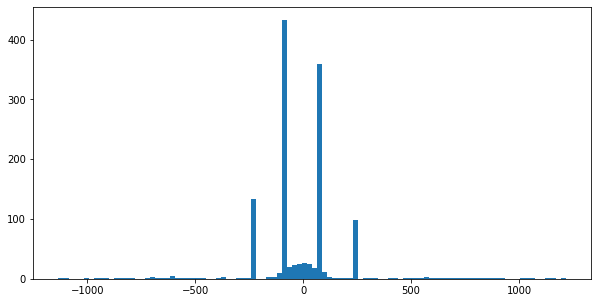

********************************************************
SCORING using weak_tracks
{'efficiency': 0.12788906009244994, 'fake_rate': 0.6286353467561522, 'clone_rate': 0.0}


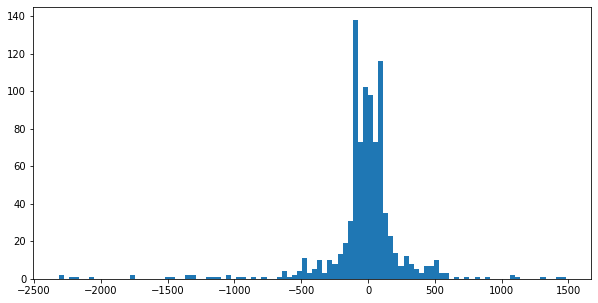

********************************************************
SCORING using frozen_tracks
{'efficiency': 0.36902927580893685, 'fake_rate': 0.4487917146144994, 'clone_rate': 0.0011507479861910242}


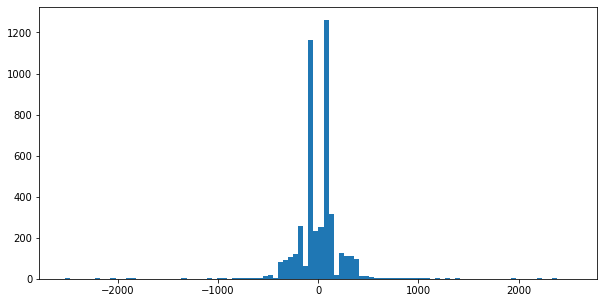

********************************************************
SCORING using all tracks
{'efficiency': 0.7434514637904468, 'fake_rate': 0.4126597687157638, 'clone_rate': 0.0018259281801582471}


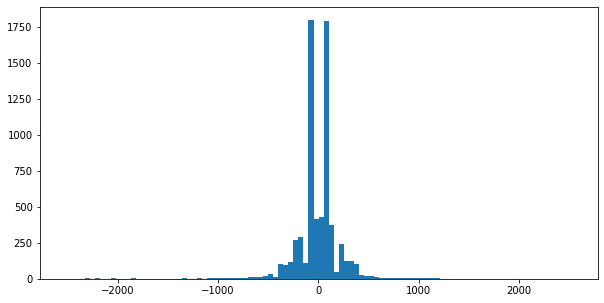

 ... Finally, done
Seeing the fake tracks 


In [33]:
search_by_triplet(False)

In [34]:
df_real_tracks = df.groupby(['particle_id'])['hit_id'].unique()

Plotting the residuals tracks


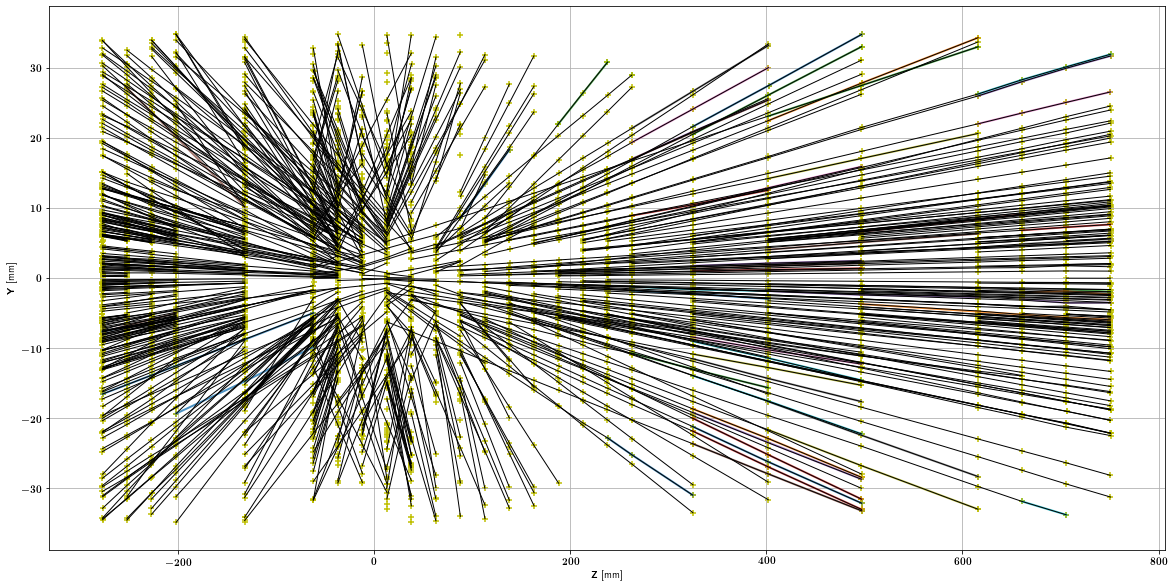

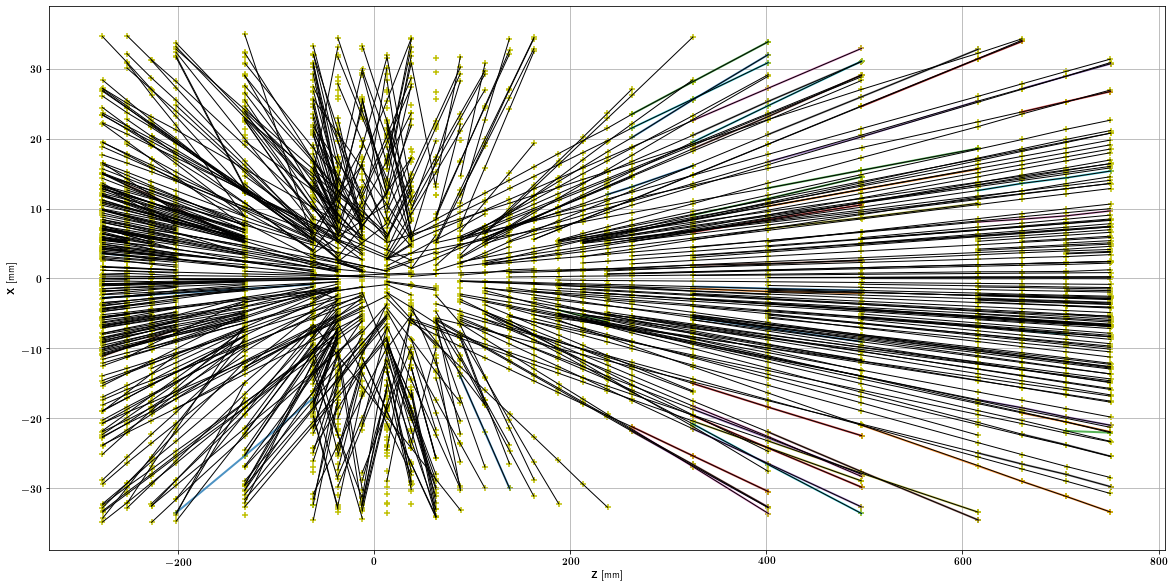

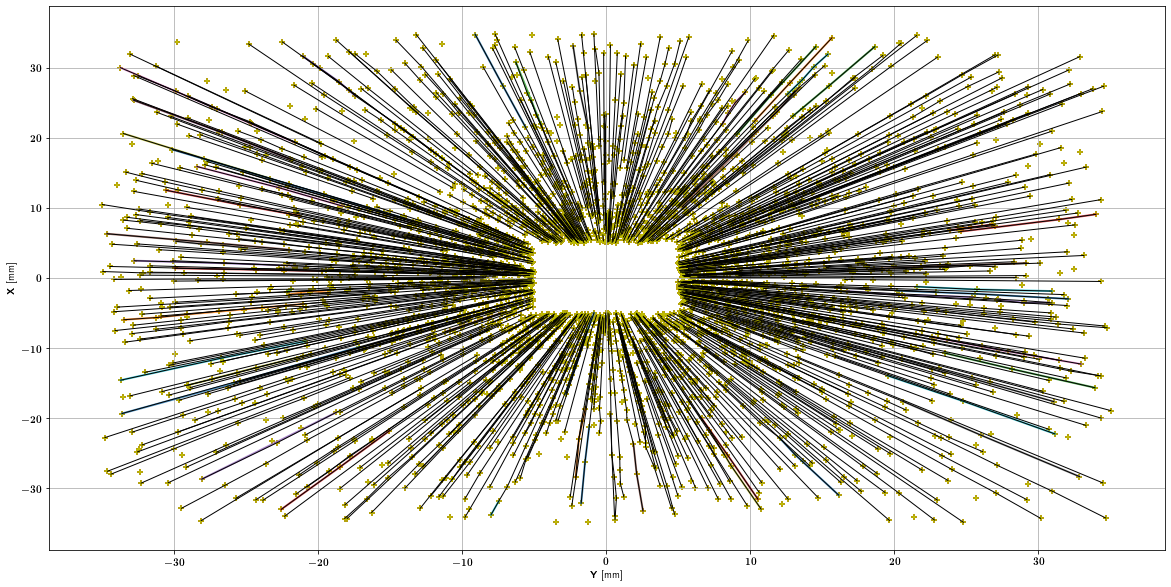

In [35]:
FilteringTracks(df_real_tracks, tracks + frozen_tracks + weak_tracks )

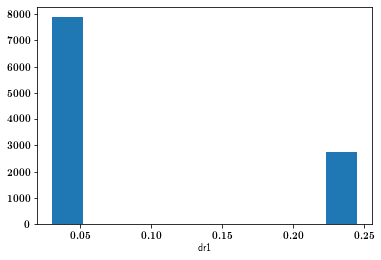

0.08599331269510607

In [36]:
plt.hist(GRALDR1)     
plt.xlabel(" dr1 ")
plt.show()    
np.mean(GRALDR1)  

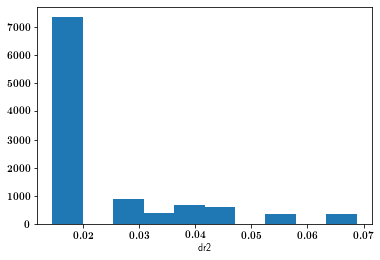

0.02279157863731147

In [37]:
plt.hist(GRALDR2)    
plt.xlabel(" dr2 ")
plt.show()           
np.mean(GRALDR2)   

# Making Plots

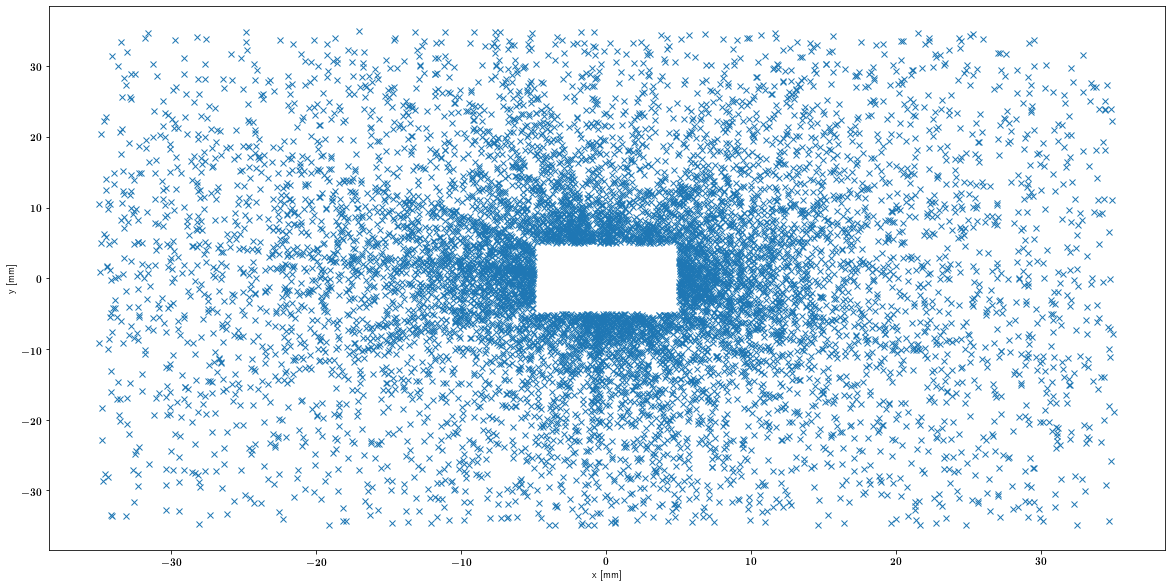

In [38]:
plt.figure(figsize=(20,10))
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
plt.plot(df.x.values,df.y.values, 'x')

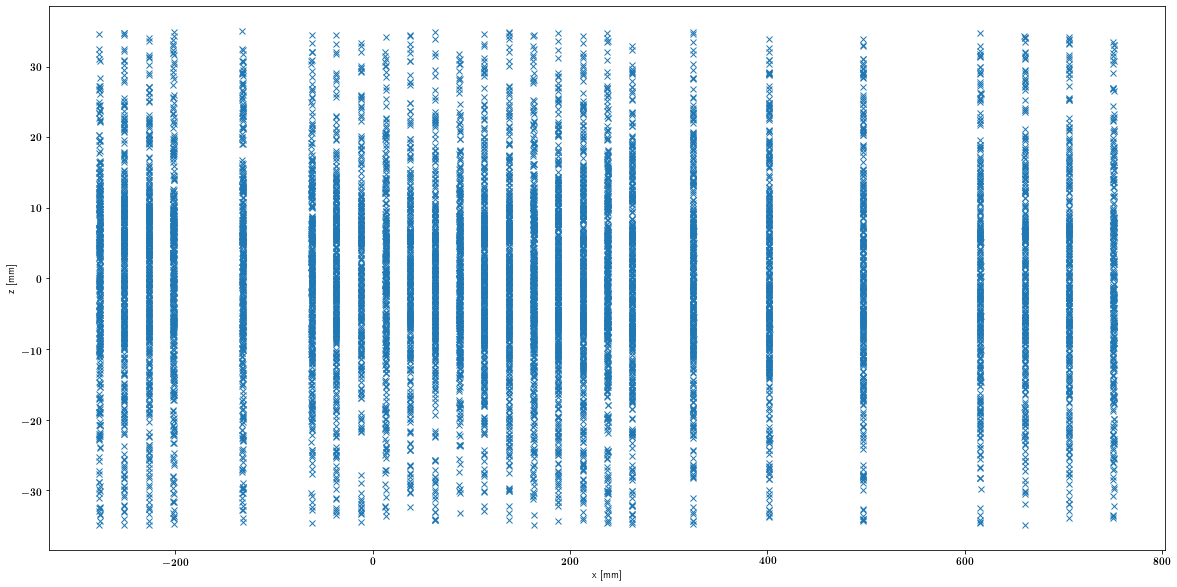

In [39]:
plt.figure(figsize=(20,10))
plt.xlabel('x [mm]')
plt.ylabel('z [mm]')
plt.plot(df.z.values,df.x.values, 'x')

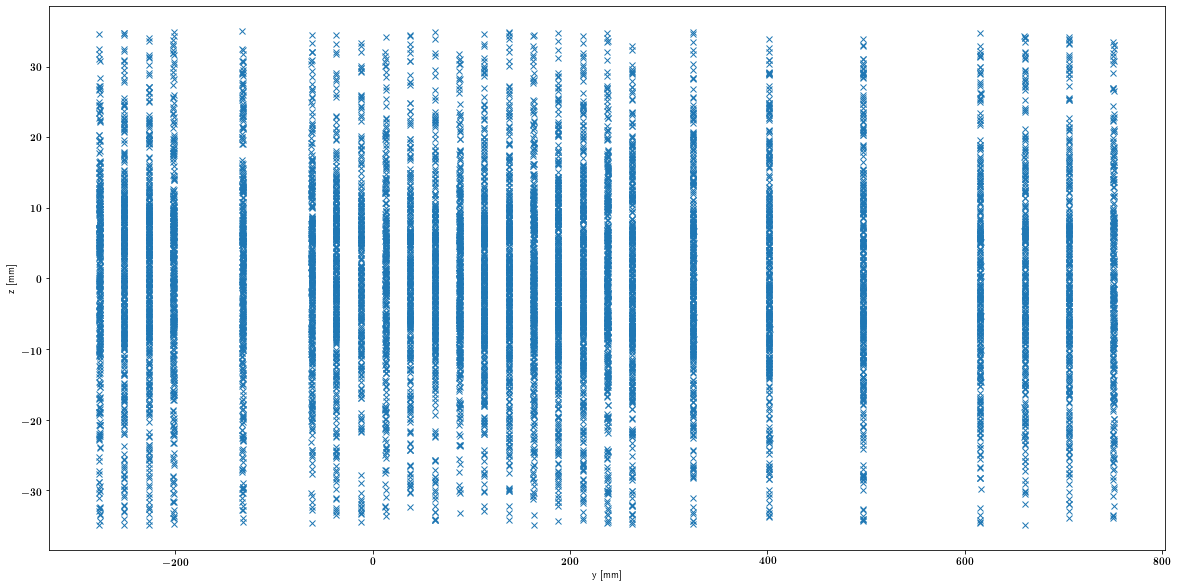

In [40]:
plt.figure(figsize=(20,10))
plt.xlabel('y [mm]')
plt.ylabel('z [mm]')
plt.plot(df.z.values,df.x.values, 'x')